In [ ]:
import pandas as pd

# Memuat data
df = pd.read_csv("/content/kdrama_DATASET - Worksheet.csv")

# Menampilkan struktur data
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Rank                350 non-null    object
 1   Title               350 non-null    object
 2   Year of release     350 non-null    int64 
 3   Number of Episodes  350 non-null    int64 
 4   Description         350 non-null    object
 5   Genre               350 non-null    object
 6   Tags                350 non-null    object
 7   Actors              350 non-null    object
 8   Rating              350 non-null    object
 9   Link                350 non-null    object
dtypes: int64(2), object(8)
memory usage: 27.5+ KB
None
  Rank                             Title  Year of release  Number of Episodes  \
0   #1                    Move to Heaven             2021                  10   
1   #2              Twinkling Watermelon             2023                  16   
2   #3              

In [ ]:
# Menampilkan jumlah missing values per kolom
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)


Missing values:
 Rank                  0
Title                 0
Year of release       0
Number of Episodes    0
Description           0
Genre                 0
Tags                  0
Actors                0
Rating                0
Link                  0
dtype: int64


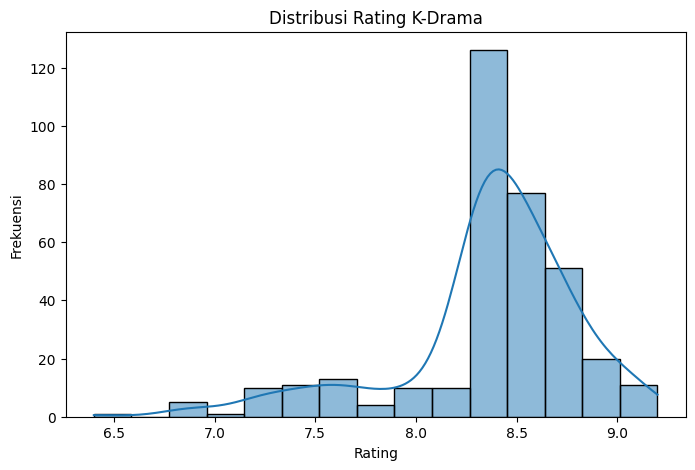

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membersihkan kolom Rating
df['Rating'] = df['Rating'].str.replace(',', '.').astype(float)

# Visualisasi distribusi rating
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=15, kde=True)
plt.title('Distribusi Rating K-Drama')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()


       Year of release  Number of Episodes      Rating
count       350.000000          350.000000  350.000000
mean       2019.808571           18.254286    8.364857
std           3.713282           14.565962    0.454704
min        2003.000000            1.000000    6.400000
25%        2018.000000           12.000000    8.300000
50%        2020.000000           16.000000    8.400000
75%        2023.000000           16.000000    8.600000
max        2025.000000          133.000000    9.200000


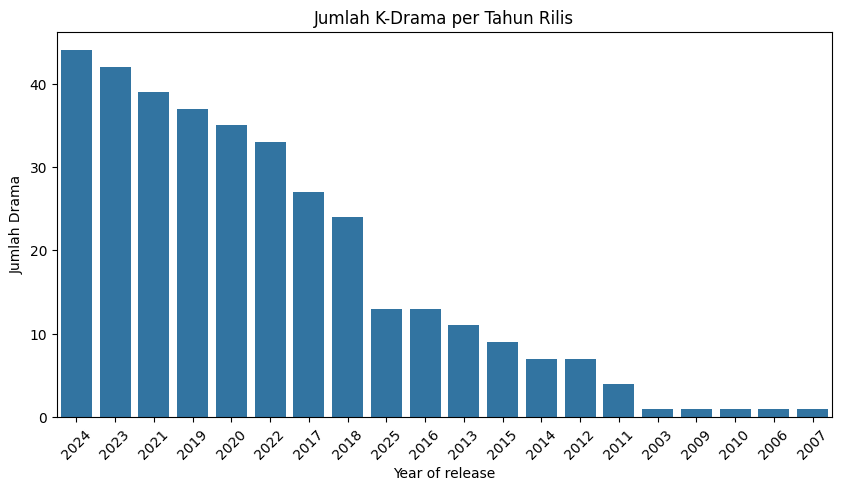

In [ ]:
# Statistik deskriptif untuk semua kolom numerik
print(df.describe())

# Frekuensi rilis per tahun
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Year of release', order=df['Year of release'].value_counts().index)
plt.title('Jumlah K-Drama per Tahun Rilis')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Drama')
plt.show()


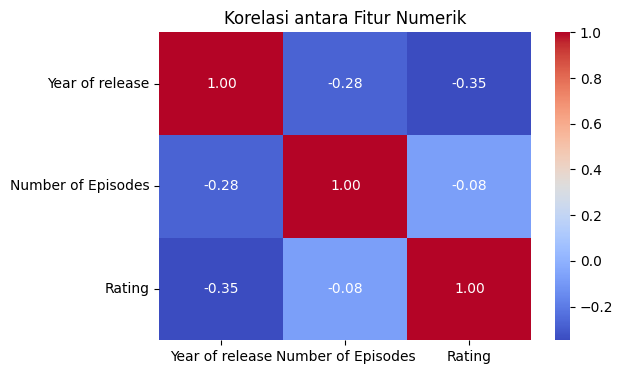

In [ ]:
# Korelasi antara fitur numerik
numerical_features = ['Year of release', 'Number of Episodes', 'Rating']
correlation = df[numerical_features].corr()

# Heatmap korelasi
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi antara Fitur Numerik')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Gabungkan fitur teks menjadi satu kolom
df['combined_features'] = (
    df['Genre'].fillna('') + ' ' +
    df['Tags'].fillna('') + ' ' +
    df['Actors'].fillna('') + ' ' +
    df['Description'].fillna('')
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

# Cosine similarity antar drama
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [ ]:
#Train ML Model
#Tidak ada model pelatihan tradisional (karena ini bukan supervised learning). Sistem rekomendasi ini menggunakan kemiripan konten (cosine similarity).

In [ ]:
def get_recommendations(title, top_n=5):
    # Cari index dari judul
    idx = df[df['Title'].str.lower() == title.lower()].index
    if idx.empty:
        return f"Drama '{title}' tidak ditemukan."
    idx = idx[0]

    # Urutkan berdasarkan similarity
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    # Ambil judul-judul terdekat
    recommended = [df.iloc[i[0]]['Title'] for i in sim_scores]
    return recommended


In [ ]:
# Contoh konversi untuk klasifikasi
df['target_class'] = df['Rating'].apply(lambda x: 1 if x >= 9.0 else 0)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Ubah jadi list
df['Genre_list'] = df['Genre'].str.split(', ')
df['Tags_list'] = df['Tags'].str.split(', ')
df['Actors_list'] = df['Actors'].str.split(', ')

# Encode masing-masing
mlb_genre = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb_genre.fit_transform(df['Genre_list']), columns=mlb_genre.classes_)

mlb_tags = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb_tags.fit_transform(df['Tags_list']), columns=mlb_tags.classes_)

mlb_actors = MultiLabelBinarizer()
actors_encoded = pd.DataFrame(mlb_actors.fit_transform(df['Actors_list']), columns=mlb_actors.classes_)


In [ ]:
numerical_features = df[['Year of release', 'Number of Episodes']].reset_index(drop=True)


In [ ]:
X = pd.concat([genre_encoded, tags_encoded, actors_encoded, numerical_features], axis=1)


In [ ]:
y = df['Rating'].apply(lambda x: 1 if x >= 9.0 else 0)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

<Axes: xlabel='Rating', ylabel='count'>

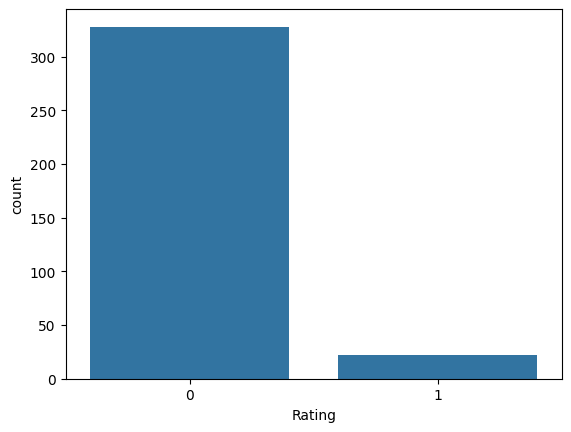

In [ ]:
import seaborn as sns
sns.countplot(x=y)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Logistic Regression pipeline
model_lr = Pipeline([
    ('scaler', StandardScaler()),  # Hanya untuk fitur numerik
    ('clf', LogisticRegression(class_weight='balanced', random_state=42))
])

# Fit model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        66
           1       0.00      0.00      0.00         4

    accuracy                           0.94        70
   macro avg       0.47      0.50      0.49        70
weighted avg       0.89      0.94      0.92        70

Random Forest Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        66
           1       0.00      0.00      0.00         4

    accuracy                           0.94        70
   macro avg       0.47      0.50      0.49        70
weighted avg       0.89      0.94      0.92        70



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix

print("ROC AUC Logistic Regression:", roc_auc_score(y_test, y_pred_lr))
print("ROC AUC Random Forest:", roc_auc_score(y_test, y_pred_rf))

ROC AUC Logistic Regression: 0.5
ROC AUC Random Forest: 0.5


In [ ]:
from sklearn.model_selection import cross_val_score

cv_score_rf = cross_val_score(model_rf, X, y, cv=5, scoring='f1')
print("F1 Score Random Forest (CV):", cv_score_rf.mean())

F1 Score Random Forest (CV): 0.0


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, cv=3, scoring='f1')
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'max_depth': None, 'n_estimators': 100}


ROC AUC Logistic Regression: 0.5
ROC AUC Random Forest: 0.5


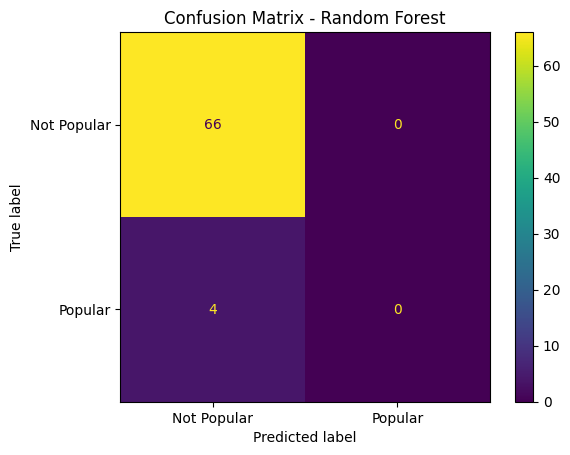

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# ROC-AUC
print("ROC AUC Logistic Regression:", roc_auc_score(y_test, y_pred_lr))
print("ROC AUC Random Forest:", roc_auc_score(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Not Popular", "Popular"])
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

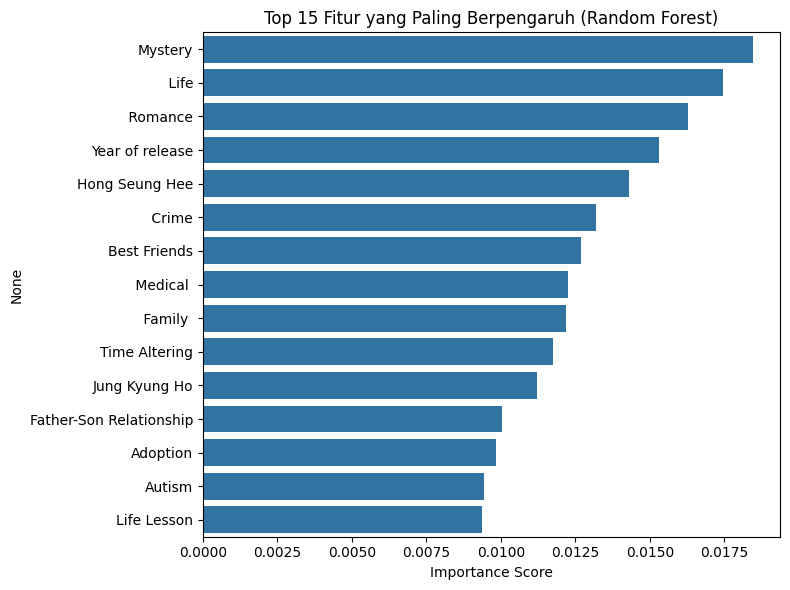

In [ ]:
importances = pd.Series(model_rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 15 Fitur yang Paling Berpengaruh (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
# Target regresi: nilai rating
y_reg = df['Rating']

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = model_reg.predict(X_test_reg)

print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg))

MAE: 0.2601973948181078
MSE: 0.132648132208225
RMSE: 0.36420891286214424
R2 Score: 0.31012158463498485


In [ ]:
X_test['y_true'] = y_test.values
X_test['y_pred'] = y_pred_rf

# Gabungkan kembali genre/tag untuk melihat pola kesalahan
X_test['Genre'] = df.loc[X_test.index, 'Genre']
false_positives = X_test[(X_test['y_true'] == 0) & (X_test['y_pred'] == 1)]

# Cek genre atau tag dominan dalam false positives
false_positives['Genre'].value_counts().head(10)

,count
Genre,


In [ ]:
y_train_pred = model_rf.predict(X_train)

from sklearn.metrics import accuracy_score, f1_score

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))

print("Train F1:", f1_score(y_train, y_train_pred))
print("Test F1:", f1_score(y_test, y_pred_rf))

Train Accuracy: 1.0
Test Accuracy: 0.9428571428571428
Train F1: 1.0
Test F1: 0.0


In [ ]:
# Keterbatasan:
# - Model ini tidak mempertimbangkan faktor eksternal seperti:
#   * Popularitas aktor di luar negeri
#   * Biaya produksi, kampanye promosi
#   * Sentimen penonton di media sosial (Twitter, TikTok, dsb)
# - Data hanya dari satu sumber (MyDramaList) dan bisa bias.
# - Rekomendasi terbatas pada konten, tidak mencakup preferensi personal pengguna.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Prediksi di data training
y_train_pred = model_rf.predict(X_train)

# Evaluasi akurasi & F1
print("=== Overfitting Check ===")
print(f"Train Accuracy : {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy  : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Train F1 Score : {f1_score(y_train, y_train_pred):.4f}")
print(f"Test F1 Score  : {f1_score(y_test, y_pred_rf):.4f}")

=== Overfitting Check ===
Train Accuracy : 1.0000
Test Accuracy  : 0.9429
Train F1 Score : 1.0000
Test F1 Score  : 0.0000


In [ ]:
"""
=== Keterbatasan Model ===

1. Data Terbatas:
   - Dataset hanya mencakup informasi dari MyDramaList, yang bisa bias secara geografis dan demografis.
   - Tidak mencakup data dari platform lain seperti Netflix, Disney+, atau data sosial media.

2. Tidak Mengakomodasi Preferensi Pribadi:
   - Sistem tidak mempertimbangkan histori tontonan atau preferensi unik tiap pengguna.

3. Fitur Eksternal Tidak Dipertimbangkan:
   - Faktor penting seperti biaya produksi, pemasaran, pengaruh viral di media sosial (TikTok, Twitter), atau penayangan eksklusif tidak masuk ke dalam fitur.

4. Popularitas Bersifat Subjektif:
   - Definisi "Popular" berbasis angka rating ≥ 9.0, padahal bisa berbeda di tiap platform atau komunitas.

5. Potensi Overfitting:
   - Jika performa model jauh lebih tinggi di data pelatihan daripada di data pengujian, kemungkinan besar model telah belajar pola spesifik yang tidak general.

6. Multigenre dan Noise Fitur:
   - Drama yang mencampur banyak genre atau tag bisa menyebabkan model bingung.
"""
